In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from preprocess_text import preprocess_text
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures
import dill
from ediblepickle import checkpoint
from urllib.parse import quote
import haversine as hs

%matplotlib notebook

In [35]:
# get the data
final_dir = r'/Users/ckrasnia/Documents/application_materials/rental_data'
data = pd.read_csv(os.path.join(final_dir,'raw_US_listings.csv'),index_col='Unnamed: 0',dtype = {'id':str, 'host_id':str, })


/Users/ckrasnia/opt/anaconda3/envs/ds_default/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (0,3,22,28,29,41,45,46,54,61,68) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
pd.options.display.max_columns=100
data.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,location
0,11464,https://www.airbnb.com/rooms/11464,20210629175854,2021-06-30,Deluxe Studio 5 min. to SC Kaiser & Apple Park,Custom built Studio with exquisite design. Rea...,10 min. to Lucky's and Starbucks at El Camino ...,https://a0.muscache.com/pictures/121321/2c5a5a...,42458,https://www.airbnb.com/users/show/42458,Emey,2009-09-30,"Mountain View, California, United States",I pride myself on attention to details and cus...,within an hour,100%,98%,t,https://a0.muscache.com/im/users/42458/profile...,https://a0.muscache.com/im/users/42458/profile...,Santa Clara,17.0,17.0,"['email', 'phone', 'reviews']",t,f,"Santa Clara, California, United States",Santa Clara,NaN,37.34415,-121.98701,Entire apartment,Entire home/apt,2.0,NaN,1 bath,NaN,0.0,"[""Iron"", ""Cooking basics"", ""Single level home""...",$85.00,4,365.0,4.0,4.0,1125.0,1125.0,4.0,1125.0,NaN,t,3.0,3.0,21.0,110,2021-06-30,9.0,3.0,0.0,2018-08-26,2021-02-20,4.44,5.00,4.89,4.89,4.78,4.78,4.67,NaN,t,16.0,16.0,0.0,0.0,0.26,"San Jose, California, United States"
1,21373,https://www.airbnb.com/rooms/21373,20210629175854,2021-06-29,Bonsai Garden Inn in Professorville,Room in gracious home with beautiful garden. ...,This room is in an ultra convenient location i...,https://a0.muscache.com/pictures/527285/0f9d08...,7054,https://www.airbnb.com/users/show/7054,Mei Lin,2009-01-24,"Palo Alto, California, United States","I have lived and worked in Asia, Europe, Austr...",within a day,100%,NaN,t,https://a0.muscache.com/im/users/7054/profile_...,https://a0.muscache.com/im/users/7054/profile_...,Palo Alto,5.0,5.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Palo Alto, California, United States",Palo Alto,NaN,37.43972,-122.15532,Private room in villa,Private room,1.0,NaN,2 shared baths,1.0,1.0,"[""Iron"", ""Cooking basics"", ""Shampoo"", ""Smoke a...",$80.00,2,730.0,2.0,2.0,730.0,730.0,2.0,730.0,NaN,t,0.0,0.0,0.0,119,2021-06-29,264.0,0.0,0.0,2018-04-13,2020-03-14,4.86,4.82,4.79,4.85,4.89,4.96,4.75,NaN,f,4.0,0.0,4.0,0.0,6.75,"San Jose, California, United States"
2,37512,https://www.airbnb.com/rooms/37512,20210629175854,2021-06-30,Private room - Parking 3 carport,We live in a safe community close to public tr...,Our community is a safe environment and at nig...,https://a0.muscache.com/pictures/47698055/32c3...,161741,https://www.airbnb.com/users/show/161741,Maria,2010-07-09,"San Jose, California, United States",I am in a committed relationship with my live...,NaN,NaN,NaN,t,https://a0.muscache.com/im/users/161741/profil...,https://a0.muscache.com/im/users/161741/profil...,South San Jose,2.0,2.0,"['email', 'phone', 'facebook', 'reviews', 'man...",t,t,"San Jose, California, United States",San Jo

In [4]:
print(len(data))
y = 90-data['availability_90']
data.groupby('location').count() # wide range of number of listings per area, could be a wee bit of an issue...

498225


,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
location,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Asheville, North Carolina, United States",7555,7555,7555,7555,7555,7545,5891,7555,7555,7555,7518,7518,7508,5073,6491,6491,6734,7518,7518,7518,1747,7518,7518,7555,7518,7518,5894,7555,0,7555,7555,7555,7555,7555,0,7554,7035,7475,7555,7555,7555,7555,7555,7555,7555,7555,7555,7555,0,7555,7555,7555,7555,7555,7555,7555,7555,7555,7099,7099,7099,7092,7092,7092,7092,7092,7092,0,7555,7555,7555,7555,7555,7099
"Austin, Texas, United States",32228,32228,32228,32228,32228,31575,19884,32225,32228,32228,32116,32116,32073,19792,19767,19767,20760,32116,32116,32116,26882,32116,32116,32228,32116,32116,19884,32228,0,32228,32228,32228,32228,32228,0,32174,30102,31385,32228,32228,32228,32228,32225,32225,32225,32225,32225,32225,0,32228,32228,32228,32228,32228,32228,32228,32228,32228,24705,24705,24705,24426,24426,24423,24426,24418,24418,0,32228,32228,32228,32228,32228,24705
"Boston, Massachusetts, United States",9509,9509,9509,9509,9509,9413,6326,9509,9509,9509,9120,9120,9116,6222,7211,7211,7371,9120,9120,9120,8557,9120,9120,9509,9120,9120,6326,9509,0,9509,9509,9509,9509,9509,0,9494,8214,9111,9509,9509,9509,9509,9503,9503,9503,9503,9503,9503,0,9509,9509,9509,9509,9509,9509,9509,9509,9509,6832,6832,6832,6793,6796,6790,6796,6790,6790,5202,9509,9509,9509,9509,9509,6832
"Cambridge, Massachusetts, United States",2414,2414,2414,2414,2414,2366,1622,2414,2414,2414,2411,2411,2408,1698,2108,2108,2119,2411,2411,2411,2287,2411,2411,2414,2411,2411,1622,2414,0,2414,2414,2414,2414,2414,0,2411,2281,2302,2414,2414,2414,2414,2414,2414,2414,2414,2414,2414,0,2414,2414,2414,2414,2414,2414,2414,2414,2414,1759,1759,1759,1746,1746,1746,1746,1746,1746,800,2414,2414,2414,2414,2414,1759
"Chicago, Illinois, United States",19334,19334,19334,19334,19334,19287,14058,19334,19334,19334,19317,19317,19288,13179,15267,15267,15891,19317,19317,19317,17881,19317,19317,19334,19317,19317,14061,19334,0,19334,19334,19334,19334,19334,0,19309,17641,18954,19334,19334,19334,19334,19334,19334,19334,19334,19334,19334,0,19334,19334,19334,19334,19334,19334,19334,19334,19334,16057,16057,16057,15958,15958,15955,15952,15955,15955,18085,19334,19334,19334,19334,19334,16057
"Columbus, Ohio, United States",2913,2913,2913,2913,2913,2902,2162,2913,2913,2913,2913,2913,2913,1955,2695,2695,2748,2913,2913,2913,2039,2913,2913,2913,2913,2913,2162,2913,0,2913,2913,2913,2913,2913,0,2913,2792,2880,2913,2913,2913,2913,2913,2913,2913,2913,2913,2913,0,2913,2913,2913,2913,2913,2913,2913,2913,2913,2575,2575,2575,2575,2575,2575,2575,2575,2575,2593,2913,2913,2913,2913,2913,2575
"Denver, Colorado, United States",11563,11563,11563,11563,11563,11464,8549,11

In [5]:

def get_bathrooms(list):
    """
    extractsr the numbers from a list of strings, specialized to the bathroom_text column
    Input : list of strings
    output : float of number of bathrooms
    """
    for item in list:
        if any([i.isnumeric() for i in item]):
            return float(item)
        elif 'half' in item.lower():
            return .5
        else:
            return np.nan

def cut_to_len(array,length):
    a_len=len(array)
    if a_len > length:
        return array[:length]
    else:
        return np.concatenate([array,np.zeros(length-a_len).astype(int)])


In [6]:
data.keys()

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

OK so the next goal is to make a regression model trying to predict the total income from a 
rental given its characteristics. So to do this I will do a few things, I will turn some 
currently non-numeric values into numeric, and I will normalize all the data into the range 0-1 
so we can easily compare the weights of the model

In [7]:
# first convert some values to numeric
# getting the bathroom count
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin

class BathroomParser(BaseEstimator, TransformerMixin):
    
    @staticmethod
    def get_bathrooms(string):
        """
        extractsr the numbers from a list of strings, specialized to the bathroom_text column
        Input : list of strings
        output : float of number of bathrooms
        """
        try:
            if np.isnan(string):
                return np.nan
        except TypeError:
            pass
        multiplier = 1 # if bathrooms are shared, I cut the count in half
        count = 0
        if string.strip().lower() == 'private':
            return 1
        if string.strip().lower() == 'shared':
            return .5
        for item in string.split():
            
            if item.isnumeric():
                count += float(item)
                
            if 'half' in item.lower():
                count += .5
                
            # if bathrooms are shared, I cut the count in half
            if 'shared' in item.lower():
                multiplier = .5
            
        return count * multiplier
            
    def get_feature_names_out(self, input_features):
        return self.names
    
    def fit(self, X, y=None):
        # This transformer doesn't need to learn anything about the data,
        # so it can just return self without any further processing
        self.names = list(X.keys())
        return self
    
    def transform(self, X):
        out = pd.DataFrame()
        for col in X:
            out[col] = X[col].apply(BathroomParser.get_bathrooms)
        return out

# test BathroomParser
print(data[['bathrooms_text']].head(),BathroomParser().fit_transform(data[['bathrooms_text']]).head())
BathroomParser().fit_transform(data[['bathrooms_text']]).shape

   bathrooms_text
0          1 bath
1  2 shared baths
2   1 shared bath
3   1 shared bath
4  2 shared baths    bathrooms_text
0             1.0
1             1.0
2             0.5
3             0.5
4             1.0


(498225, 1)

In [8]:

# there are a couple boolean columns coded as "t" and "f", replace those with 1, 0
class BoolMapper(BaseEstimator, TransformerMixin):
    
    def get_feature_names_out(self, input_features):
        return self.names
        
    def fit(self, X, y=None):
        # This transformer doesn't need to learn anything about the data,
        # so it can just return self without any further processing
        self.names = list(X.keys())
        return self
    
    def transform(self, X):
        # only change the values that are not numeric and not nan
        out = pd.DataFrame()
        for name in X:
            boolean_mapper = {'t': 1., 'f': 0., 1.: 1., 0.: 0.}
            col=X[name].map(boolean_mapper, na_action="ignore")
            out[name]=col
        return out
    
# boolean_mapper = {'t' : 1, 'f' : 0}
bools = ['instant_bookable','has_availability', 'host_has_profile_pic',
         'host_identity_verified', 'host_is_superhost']

# for column in bools:
x = BoolMapper().fit_transform(data[bools])
#     print(x.dtype)
# print(np.unique(x[x.notna()]))
x

,instant_bookable,has_availability,host_has_profile_pic,host_identity_verified,host_is_superhost
0,1.0,1.0,1.0,0.0,1.0
1,0.0,1.0,1.0,1.0,1.0
2,0.0,1.0,1.0,1.0,1.0
3,0.0,1.0,1.0,1.0,1.0
4,0.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...
38272,0.0,1.0,1.0,1.0,0.0
38273,0.0,1.0,1.0,1.0,0.0
38274,1.0,1.0,1.0,1.0,0.0
38275,1.0,1.0,1.0,1.0,0.0


In [9]:
# categorize room types
## switch to one hot encoding
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import DictVectorizer
class OHEfromDF(BaseEstimator, TransformerMixin):
    """
    Transformer class that formats pandas columns with string values into a valid input for the
    DictVectorizer function to create a one-hot encoding.
    
    params : vals (None or list)
                The values to use for one-hot encoding, they can either be fed in at intitialization or 
                fit by taking all the values that are more common than len(X)/val_cutoff
           : val_cutoff (float) the number >1 to use to select the vals in the fit method as described above.
                val_cutoff=1 means select all values, larger number provides a stricter cutoff
    """
    def __init__(self,vals=None,val_cutoff=100):
        self.vals = vals
        self.val_cutoff=val_cutoff
    
    def get_feature_names_out(self, input_features):
        return self.names
    
    def fit(self, X, y=None):
        # can either provide value, or, can fit them based on the most common entries
        if self.vals == None:
            vals = list(X.value_counts()[X.value_counts()>len(data)/self.val_cutoff].index)
            self.vals = [val[0] for val in vals]
        self.names = []
        for col in X:
            self.names.extend([col+'_'+val for val in self.vals])
        return self
    
    def transform(self, X):
        # only change the values that are not numeric and not nan
        mapper = {val:i for i,val in enumerate(self.vals)}
        new_X = pd.DataFrame()
        for col in X:
            col_names = [col+'_'+val for val in self.vals]
            temp = X[col].map(mapper, na_action="ignore")
            for i,name in enumerate(col_names):
                new_X[name] = (temp == i).astype(float)
        return new_X

OHEfromDF().fit_transform(data[['host_response_time']])# rt_mapper = {'Entire home/apt' : 3, 'Private room' : 2, 'Hotel room' : 1}
# data['room_type'] = data['room_type'].map(rt_mapper)
# # the nan room types are shared, so assign these to 0
# data['room_type'][data['room_type'].isna()] = 0
# # I think I want to have this one-hot instead, so going to add that here
# data['room_type_entire'] = data['room_type'].map({3:1, 2:0, 1:0, 0:0})
# data['room_type_private'] = data['room_type'].map({2:1, 3:0, 1:0, 0:0})
# data['room_type_hotel'] = data['room_type'].map({1:1, 3:0, 2:0, 0:0})
# data['room_type_none'] = data['room_type'].map({0:1, 3:0, 2:0, 1:0})

,host_response_time_within an hour,host_response_time_within a few hours,host_response_time_within a day,host_response_time_a few days or more
0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0
...,...,...,...,...
38272,0.0,1.0,0.0,0.0
38273,0.0,1.0,0.0,0.0
38274,1.0,0.0,0.0,0.0
38275,1.0,0.0,0.0,0.0


One of the limitations of this dataset is that we don't know when listings are actually rented versus made unavailable by the host. One thing I can probably do is try to find listings that are only occasionally made available by the host. This is assuming that there are two main categories of listings, some that are regularly available for rent, and some that a host will only make available when they are not at their home, I think we want to exclude the last ones. To get at this I will use the `availability_365` column, with the assumption that properties that are never or hardly available, and those that are always available, are probably not going to be too informative for our model.

In [10]:
# take a look at how many properties would be dropped if we excluded at different cutoffs of this column
out=[]
for i in np.linspace(0,1,100):
    out.append((data['availability_365']<=i).sum())
fig,ax=plt.subplots()
plt.plot(np.linspace(0,1,100),np.array(out)/len(data)*100)
ax.set(ylabel='% of values below',xlabel='fraction of days available')

TypeError: '>=' not supported between instances of 'numpy.ndarray' and 'str'

In [10]:
# there seems to be some erroneous entries here that we need to remove

class FilterOutFakes(BaseEstimator, TransformerMixin):
    """
    transformer to filter our the properties that have 0 availability over the next year, they probably
    aren't going to be useful to train on, also drops any rows where the availability_90 (outcome variable) 
    is nan
    
    Input : pd.DataFrame with the column 'availability_365'
    
    param cutoff: the integer value from 0-365 used to exclude listings. the excludion works as:
                    availability_365 > cutoff
    """
    
    def __init__(self, max = 365,min=0):
        self.max = max
        self.min = min
        
    def get_feature_names_out(self, input_features):
        return self.names
        
    def fit(self, X, y=None):
        # This transformer doesn't need to learn anything about the data,
        # so it can just return self without any further processing
        self.names = list(X.keys())
        return self
    
    def transform(self, X):
        vals=pd.to_numeric(X['availability_365'],errors='coerce')
        X = X[(vals > self.min) & (vals <= self.max)]
        X = X[X['availability_90']!=90]
        X = X[X['availability_90']!=0]
        return X.dropna(subset=['availability_90'])

print(len(data))
FilterOutFakes(min=14,max=365).fit_transform(data).shape


# list365=np.zeros(len(data['availability_365']))
# for i,val in enumerate(data['availability_365']):
#     try: 
#         list365[i] = float(val)/365
#     except:
#         list365[i] = np.nan
# data['availability_365'] = list365.astype(float)


498225


(309547, 75)

In [37]:
# hs.haversine(geocode('Santa Clara, California, United States'),(37.34415,-121.98701))
data[['latitude','longitude','neighbourhood']].head(20)
data['location'].iloc[27200+52478]

nan

In [ ]:
DistFromCenter().fit_transform(data[:1000])

In [11]:
from datetime import datetime
class HostLength(BaseEstimator, TransformerMixin):
    """
    calculate the length of time the person has been a host, take the diff og host_since and date_scraped
    
    """
      
    def fit(self, X, y=None):
        # This transformer doesn't need to learn anything about the data,
        # so it can just return self without any further processing
        self.names = ['host_length_days']
        return self
    
    def get_feature_names_out(self, input_features):
        return self.names
    
    def transform(self, X):
        #calculate time delta since airbnb was founded
        X['host_length_days'] = pd.DataFrame((pd.to_datetime(X['calendar_last_scraped'],errors='coerce') - pd.to_datetime(X['host_since'],errors='coerce')).dt.days)
        return X
## test this
HostLength().fit_transform(data)['host_length_days']

0        4291.0
1        4539.0
2        4009.0
3        4009.0
4        4539.0
          ...  
38272    1874.0
38273    1874.0
38274     653.0
38275     653.0
38276    2112.0
Name: host_length_days, Length: 498225, dtype: float64

In [12]:
class FloatCaster(BaseEstimator, TransformerMixin):
    """
    
    """
      
    def get_feature_names_out(self, input_features):
        return self.names
        
    def fit(self, X, y=None):
        # This transformer doesn't need to learn anything about the data,
        # so it can just return self without any further processing
        self.names = list(X.keys())
        return self
    
    
    def transform(self, X):
        out = pd.DataFrame()
        for name in X:
            col = X[name]
            # if its already 
            numerics = 0
            # heuristic to get columns that are mostly numeric and just have a few non-numeric columns
            for i in range(int(np.ceil(len(X)/10))):
                if (type(col.iloc[i]) == int) | (type(col.iloc[i]) == float):
                    numerics+=1
            if numerics >= len(X)/10-(len(X)/10/10):
                out[name] = pd.to_numeric(col,errors='coerce')
            else:
            # deals with columns that are strings but really should be numbers like things with $ or %
                out[name] = pd.to_numeric(col.str.replace(r'[^0-9\.]+',''),errors='coerce')
        return out
FloatCaster().fit_transform(data[['minimum_nights']].iloc[:1])
# type(data['minimum_nights'].iloc[0])#.str.replace(r'[^0-9\.]+','')

,minimum_nights
0,4


In [13]:

class BedandBedroomImputer(BaseEstimator, TransformerMixin):
    """
    A transformer to impute the number of bedrooms/beds from the number of people it accommodates,
    fit method calculates the mean ratio of accomodates to the column in question (beds or bedrooms)
    for non-null values, and fills in the estimated number of beds/bedrooms based on this mean ratio
    Input should be the whole dataframe, with an accommodates, beds, and bedrooms column
    """
      
    def fit(self, X, y=None):
        bed_mask = X['beds'].notna()
        self.bed_ratio_ = (X['beds'][bed_mask] / X['accommodates'][bed_mask]).mean()
        bedroom_mask = X['bedrooms'].notna()
        self.bedroom_ratio_ = (X['beds'][bedroom_mask] / X['accommodates'][bedroom_mask]).mean()
        return self
    
    def transform(self, X):
        # fill in where accommodates is not nan
        bed_mask = X['beds'].isna()
        X['beds'][bed_mask] = X['accommodates'][bed_mask] * self.bed_ratio_
        bedroom_mask = X['bedrooms'].isna()
        X['bedrooms'][bedroom_mask] = X['accommodates'][bedroom_mask] * self.bedroom_ratio_
        return X
## test this

BedandBedroomImputer().fit_transform(data).shape

/Users/ckrasnia/opt/anaconda3/envs/ds_default/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ckrasnia/opt/anaconda3/envs/ds_default/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/ckrasnia/opt/anaconda3/envs/ds_default/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

(498225, 76)

In [67]:
## add in text data
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.pipeline import FeatureUnion

lemmatizer = WordNetLemmatizer()
sw = stopwords.words('english')
sw.extend(["'d", "'ll", "'re", "'s", "'ve", 'could', 'doe', 'ha', 'might', 'must', "n't", 'need', 'sha', 'wa', 'wo', 'would'])
def remove_md(string):
    """
    Removes angled brackets (< & >) and the markdown formatting inside them from strings. Should 
    remove anything between two angled brackets, anything before a close bracket if there is only a
    close bracket, and anything after an open bracket if there is only an open bracket
    
    Input : str
    output : str
    """

    # if both an open and close angle brackets are in the string
    if ('<' in string) and ('>' in string):
        open_brac = string.find('<')
        close_brac = string.find('>')
        # if there is something inside the brackets, drop that including the brackets
        if open_brac < close_brac:
            string = string.replace(string[open_brac : close_brac + 1]," ")
        # if there isn't anything in between them, drop everything before and after
        else:
            string = string.replace(string[:close_brac+1]," ")
            string = string.replace(string[open_brac:]," ")
        # use recursion to fix any instances where there are multiple opens and closes
        return remove_md(string)
    elif ('<' in string):
        open_brac = string.find('<')
        string = string.replace(string[open_brac:]," ")
        return remove_md(string)
    elif ('>' in string):
        close_brac = string.find('>')
        string = string.replace(string[:close_brac+1]," ")
        return remove_md(string)
    else:
        return string
    
    
def clean_text(df):
    new_df = pd.DataFrame()
    for col in df:
        column = df[col]
        column[column.isna()] = ''
        #look at the original distribution of how many words there are per description
        column = column.apply(remove_md)
        #also going to want to remove some punctuation
        column = column.str.replace("[():!.,?/]"," ")
        new_df[col] = column
    return new_df


def tokenize_lemma(text):
    return [lemmatizer.lemmatize(token) for token in word_tokenize(text)]

from sklearn.decomposition import TruncatedSVD
# X=data.head(100000)
# cleaned=clean_text(X[['description','name']])
tfidf = TfidfVectorizer(ngram_range=(1,2),min_df = 10,max_df = .25,stop_words=sw, tokenizer=tokenize_lemma)
CT_words = ColumnTransformer([
                              ('tfidf_des',tfidf,'description'),
                              ('tfidf_name',TfidfVectorizer(ngram_range=(1,2),min_df = 10, max_df = .5, stop_words=sw,tokenizer=tokenize_lemma),'name'),
                              ('columnvector',CountVectorizer(max_features=1000),'amenities')
                             ])
word_pipe = Pipeline([
                      ('text_concater',TextConcater(['amenities'])),
                      ('word_clean',TextCleaner(['description','amenities','name'])),
                      ('ct_words',CT_words)
                     ])
train_x = word_pipe.fit_transform(data)
train_x

/Users/ckrasnia/opt/anaconda3/envs/ds_default/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ckrasnia/opt/anaconda3/envs/ds_default/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/ckrasnia/opt/anaconda3/envs/ds_default/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: The default value of regex will change from True to False in a future version.


<498225x459478 sparse matrix of type '<class 'numpy.float64'>'
	with 89091641 stored elements in Compressed Sparse Row format>

In [ ]:
from sklearn.linear_model import LassoCV,RidgeCV
nb = MultinomialNB()
lm = RidgeCV(alphas=np.logspace(-4,0,5), cv=3)
drop_na = data['availability_90'].notna() & (data['availability_90'] != 0) & (data['availability_90'] != 90)
lm.fit(train_x[drop_na],data['availability_90'][drop_na].astype(int))
print(lm.alpha_)
print(lm.score(train_x[drop_na],data['availability_90'][drop_na].astype(int)))


In [ ]:
word_pipe[-1].explained_variance_ratio_.sum()

In [23]:
nb.fit(train_x[drop_na],data['availability_90'][drop_na].astype(int))
print(nb.score(train_x[drop_na],data['availability_90'][drop_na].astype(int)))
print(nb.score(train_x[drop_na],np.random.permutation(data['availability_90'][drop_na].astype(int))))

ValueError: Negative values in data passed to MultinomialNB (input X)

In [18]:

class NLPTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self,use_col, vectorizer):
        
        CT_words = ColumnTransformer([(f'vectorize_{use_col}',vectorizer,use_col)
                                     ])
        if use_col == 'amenities':
            word_pipe = Pipeline([('text_concater',TextConcater([use_col])),
                                  ('word_clean',TextCleaner([use_col])),
                                  ('ct_words',CT_words),
                                  ('nb',MultinomialNB())
                                 ])
        else:
            word_pipe = Pipeline([('word_clean',TextCleaner([use_col])),
                                  ('ct_words',CT_words),
                                  ('nb',MultinomialNB())
                                 ])
        self.pipe = word_pipe
        self.use_col = use_col
        
    
    def fit(self, X, y=None):
        nan_drop = X[self.use_col].notna() & y.notna()
        self.pipe.fit(X[nan_drop],y[nan_drop].astype(int))
        
        return self
    
    def transform(self, X):
        not_na = X[self.use_col].notna()
        X[self.use_col][not_na] = self.pipe.predict(X[not_na])
        X[self.use_col] = pd.to_numeric(X[self.use_col],errors='coerce')
        return X
    

In [44]:
def tokenize_lemma(text):
    return [lemmatizer.lemmatize(token) for token in word_tokenize(text)]
tfidf = TfidfVectorizer(ngram_range=(1,2),min_df = 12,max_df = .1,stop_words=sw,tokenizer=tokenize_lemma)

# des_nlp = NLPTransformer(['description'],tfidf)
amen_nlp = NLPTransformer('amenities',CountVectorizer(max_features=1000)).fit_transform(data,data['availability_90'])

/Users/ckrasnia/opt/anaconda3/envs/ds_default/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ckrasnia/opt/anaconda3/envs/ds_default/lib/python3.7/site-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/Users/ckrasnia/opt/anaconda3/envs/ds_default/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,location,host_length_days
0,11464,https://www.airbnb.com/rooms/11464,20210629175854,2021-06-30,Deluxe Studio 5 min. to SC Kaiser & Apple Park,Custom built Studio with exquisite design. Rea...,10 min. to Lucky's and Starbucks at El Camino ...,https://a0.muscache.com/pictures/121321/2c5a5a...,42458,https://www.airbnb.com/users/show/42458,Emey,2009-09-30,"Mountain View, California, United States",I pride myself on attention to details and cus...,within an hour,100%,98%,t,https://a0.muscache.com/im/users/42458/profile...,https://a0.muscache.com/im/users/42458/profile...,Santa Clara,17.0,17.0,"['email', 'phone', 'reviews']",t,f,"Santa Clara, California, United States",Santa Clara,NaN,37.34415,-121.98701,Entire apartment,Entire home/apt,2.0,NaN,1 bath,1.176867,0.0,0,$85.00,4,365.0,4.0,4.0,1125.0,1125.0,4.0,1125.0,NaN,t,3.0,3.0,21.0,110,2021-06-30,9.0,3.0,0.0,2018-08-26,2021-02-20,4.44,5.00,4.89,4.89,4.78,4.78,4.67,NaN,t,16.0,16.0,0.0,0.0,0.26,"San Jose, California, United States",4291.0
1,21373,https://www.airbnb.com/rooms/21373,20210629175854,2021-06-29,Bonsai Garden Inn in Professorville,Room in gracious home with beautiful garden. ...,This room is in an ultra convenient location i...,https://a0.muscache.com/pictures/527285/0f9d08...,7054,https://www.airbnb.com/users/show/7054,Mei Lin,2009-01-24,"Palo Alto, California, United States","I have lived and worked in Asia, Europe, Austr...",within a day,100%,NaN,t,https://a0.muscache.com/im/users/7054/profile_...,https://a0.muscache.com/im/users/7054/profile_...,Palo Alto,5.0,5.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Palo Alto, California, United States",Palo Alto,NaN,37.43972,-122.15532,Private room in villa,Private room,1.0,NaN,2 shared baths,1.000000,1.0,0,$80.00,2,730.0,2.0,2.0,730.0,730.0,2.0,730.0,NaN,t,0.0,0.0,0.0,119,2021-06-29,264.0,0.0,0.0,2018-04-13,2020-03-14,4.86,4.82,4.79,4.85,4.89,4.96,4.75,NaN,f,4.0,0.0,4.0,0.0,6.75,"San Jose, California, United States",4539.0
2,37512,https://www.airbnb.com/rooms/37512,20210629175854,2021-06-30,Private room - Parking 3 carport,We live in a safe community close to public tr...,Our community is a safe environment and at nig...,https://a0.muscache.com/pictures/47698055/32c3...,161741,https://www.airbnb.com/users/show/161741,Maria,2010-07-09,"San Jose, California, United States",I am in a committed relationship with my live...,NaN,NaN,NaN,t,https://a0.muscache.com/im/users/161741/profil...,https://a0.muscache.com/im/users/161741/profil...,South San Jose,2.0,2.0,"['email', 'phone', 'facebook', 'reviews', 'man...",t,t,"San Jose, California, United States",San Jose,NaN,37.30423,-121.84088,Private room in bungalow,Private room,2.0,NaN

In [16]:
class TextCleaner(BaseEstimator, TransformerMixin):
    """

    """
    def __init__(self,cols):
        self.cols = cols
        
    def fit(self, X, y=None):

        return self
    
    def transform(self, X):
        new_df = pd.DataFrame()
        for col in self.cols:
            column = X[col]
            column[column.isna()] = ''
            #look at the original distribution of how many words there are per description
            column = column.apply(remove_md)
            #also going to want to remove some punctuation
            column = column.str.replace("[():!.,?/]"," ")
            X[col] = column
        return X
    
class TextConcater(BaseEstimator, TransformerMixin):
    def __init__(self,cols):
        self.cols = cols
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        new_df = X.copy()
        for col in self.cols:
            column = X[col]  # each value looks like its a list but is actually a str containing a list
            column[column.isna()] = '['']'
            column = column.apply(lambda x: ' '.join(eval(x)) if isinstance(eval(x),list) else '')
            new_df[col] = column
        return new_df
# TextCleaner().fit_transform(TextConcater().fit_transform(data))

In [17]:

cache_dir = 'cache'
if not os.path.exists(cache_dir):
    os.mkdir(cache_dir)

if not 'temp_cache' in locals():
    temp_cache = {}
@checkpoint(key=lambda args, kwargs: quote(args[0]) + '.pkl', work_dir=cache_dir)
def get_lat_long(address):
    # first check if we already loaded it this session, if so it will be much faster to grab it from here than
    # load it from memory or get it from the api
    latlong = temp_cache.get(address)
    if latlong:
        return latlong
    params = { 'format'        :'json', 
               'addressdetails': 1, 
               'q'             : address}
    headers = { 'user-agent'   : 'TDI' }
    response = requests.get('http://nominatim.openstreetmap.org/search', 
                        params=params, headers=headers)
    try:
        lat = response.json()[0]['lat']
        long = response.json()[0]['lon']
    except IndexError:
        print(f'No location on openstreetmap found for {address}, returning nan')
        temp_cache[address] = (np.nan, np.nan)
        return (np.nan, np.nan)
    
    temp_cache[address] = (float(lat),float(long))
    return (float(lat),float(long))


class DistFromCenter(BaseEstimator, TransformerMixin):
    """
    transformer to get the distance from the neighborhood center of the listing. If there is no neighborhood,
    it uses the city center. This takes a long time, but I have to iterate through them individually to keep 
    from pinging the API too many times at once and to check if I can use the neighbourhood or have to use 
    the city
    
    """
      
    def fit(self, X, y=None):
        # This transformer doesn't need to learn anything about the data,
        # so it can just return self without any further processing
        self.names = ['dist_from_center']
        return self
    
    def get_feature_names_out(self, input_features):
        return self.names
    
    def transform(self, X):
        loc1 = [(x,y) for x,y in zip(X['latitude'],X['longitude'])]
        dist = np.ones(len(X))*np.nan
        
        # this is required to keep the cache from creating a new directory when there is something like Cambridge/Boston
        X['neighbourhood'] = X['neighbourhood'].str.replace('/',' ')
        for i, l1 in enumerate(tqdm(loc1)):
            l2 = (np.nan,np.nan)
            # first get neighborhood lat,long
            if type(X['neighbourhood'].iloc[i]) == str:
                l2 = get_lat_long(X['neighbourhood'].iloc[i])
            
            #if l2 is nan or if the neighbourhood is nan, use the city instead
            if (X['neighbourhood'].isna().iloc[i]) | any(map(np.isnan,l2)):
                if X['location'].isna().iloc[i]:
                    # if both location and neighborhood are nan, return something really far away, so that the distance
                    # will be really far and return nan in the end
                    l2 = get_lat_long('Beijing, China')
                else:
                    l2 = get_lat_long(X['location'].iloc[i])
                
            dist[i] = hs.haversine(l1,l2)
            # if the distance is outrageous, set it to nan
            if dist[i] >= 1000:
                dist[i] = np.nan
        X['dist_from_center'] = dist.reshape(-1,1)        
        return X

In [739]:
%%time
# lets put all these elements together into a pipeline to see what the final output looks like in terms of nan values
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures
y = 'availability_90'

# BathroomParser()
# 'bathrooms_text'
def tokenize_lemma(text):
    return [lemmatizer.lemmatize(token) for token in word_tokenize(text)]
tfidf = TfidfVectorizer(ngram_range=(1,2),min_df = .001,max_df = .05,stop_words=sw,tokenizer=tokenize_lemma)

des_nlp = NLPTransformer(['description'],tfidf)
amen_nlp = NLPTransformer(['amenities'],CountVectorizer(max_features=1000)).fit_transform(data,data['availability_90'])
# FloatCaster()
to_floats = ['price','host_response_rate','minimum_nights','host_acceptance_rate','host_listings_count',
             'maximum_maximum_nights','review_scores_rating']

# TimeDelta()
# 'host_since'

# BoolMapper()
bools = ['host_is_superhost','host_has_profile_pic','host_identity_verified','instant_bookable']

OHEfromDF(vals = ['Entire home/apt', 'Private room', 'Shared room', 'Hotel room'])
#'property_type'
#passthrough
passthroughs = ['accommodates','beds','bedrooms','minimum_minimum_nights',
                'reviews_per_month','review_scores_value','review_scores_location','review_scores_communication',
                'review_scores_checkin','review_scores_cleanliness','review_scores_accuracy','availability_90']
text = ['name','amenities','description']

all_used = text+ to_floats + bools + passthroughs + ['property_type'] + ['location'] + ['bathrooms_text'] + ['host_response_time']

# full_df
tfidf = TfidfVectorizer(ngram_range=(1,2),min_df = .001,max_df = .05,stop_words=sw,tokenizer=tokenize_lemma)

CT1 = ColumnTransformer([('floatify',FloatCaster(),to_floats),
                         ('bathrooms',BathroomParser(),['bathrooms_text']),
                         ('boolify',BoolMapper(),bools),
                         ('prop_ohe',OHEfromDF(vals = ['Entire home/apt', 'Private room', 'Shared room', 'Hotel room']),['property_type']),
                         ('resp_time_ohe',OHEfromDF(),['host_response_time']),
                         ('loc_ohe',OHEfromDF(vals=list(data['location'].dropna().unique())),['location']),
                         ('tfidf_des',tfidf,'description'),
                         ('tfidf_name',TfidfVectorizer(min_df = .01,max_df = .5, stop_words=sw,tokenizer=tokenize_lemma),'name'),
                         ('columnvector',CountVectorizer(max_features=1000),'amenities'),
                         ('passthrough','passthrough',passthroughs)
                        ])

CT2 = ColumnTransformer([('poly_price',PolynomialFeatures(3),[0])],remainder='passthrough')
preprocc_pipeline = Pipeline([('host_length',HostLength()),
                              ('BnB',BedandBedroomImputer()),
                              ('remove_fakes',FilterOutFakes()),
                              ('location',DistFromCenter()), 
                              ('text_concater',TextConcater()),
                              ('word_clean',TextCleaner()),
                              ('columns',CT1),
                              ('poly_price',CT2)
                             ])
cleaned_data = preprocc_pipeline.fit_transform(data)
# TODO add feature for date scraped and try training different models for each city

/Users/ckrasnia/opt/anaconda3/envs/ds_default/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ckrasnia/opt/anaconda3/envs/ds_default/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/ckrasnia/opt/anaconda3/envs/ds_default/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

CPU times: user 1h 19min 27s, sys: 29.9 s, total: 1h 19min 57s
Wall time: 1h 19min 55s


In [740]:
with open('preprocess_pipe.pkl','wb') as f:
    dill.dump(preprocc_pipeline,f)

In [787]:
CT2.get_feature_names_out()[-40:]

array(['remainder__x14303', 'remainder__x14304', 'remainder__x14305',
       'remainder__x14306', 'remainder__x14307', 'remainder__x14308',
       'remainder__x14309', 'remainder__x14310', 'remainder__x14311',
       'remainder__x14312', 'remainder__x14313', 'remainder__x14314',
       'remainder__x14315', 'remainder__x14316', 'remainder__x14317',
       'remainder__x14318', 'remainder__x14319', 'remainder__x14320',
       'remainder__x14321', 'remainder__x14322', 'remainder__x14323',
       'remainder__x14324', 'remainder__x14325', 'remainder__x14326',
       'remainder__x14327', 'remainder__x14328', 'remainder__x14329',
       'remainder__x14330', 'remainder__x14331', 'remainder__x14332',
       'remainder__x14333', 'remainder__x14334', 'remainder__x14335',
       'remainder__x14336', 'remainder__x14337', 'remainder__x14338',
       'remainder__x14339', 'remainder__x14340', 'remainder__x14341',
       'remainder__x14342'], dtype=object)

# Start from here for model fitting

In [34]:
# data = pd.read_csv(os.path.join(final_dir,'raw_US_listings.csv'),index_col='Unnamed: 0',dtype = {'id':str, 'host_id':str, })
with open('preprocess_pipe.pkl','rb') as f:
    preprocc_pipeline2 = dill.load(f)
cleaned_data = preprocc_pipeline2.transform(data)

/Users/ckrasnia/opt/anaconda3/envs/ds_default/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ckrasnia/opt/anaconda3/envs/ds_default/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/ckrasnia/opt/anaconda3/envs/ds_default/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

In [35]:
#predict occupancy  
y = cleaned_data[:,-1]
X = cleaned_data[:,:-1]
X = pd.DataFrame.sparse.from_spmatrix(X)
X.shape

(326625, 14345)

In [38]:
from xgboost import XGBRegressor,XGBClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
monotone_constraints1=np.zeros(X.shape[1])
monotone_constraints2=np.zeros(X.shape[1])
monotone_constraints1[-12:-9]=1
monotone_constraints1 = {str(i):int(con) for i,con in enumerate(monotone_constraints1)}
params = {'n_estimators':[4000],'max_depth':[16,],'monotone_constraints':[monotone_constraints1,monotone_constraints2]}

xgb = XGBRegressor(reg_alpha=.1,eta=.01,n_estimators=4500,n_jobs=12,max_depth=6,colsample_bytree=.6, base_score=1/90, gamma=0,subsample=.75)
gridsearch = GridSearchCV(xgb,params,cv=3,verbose=2)


X_train,X_test,y_train,y_test = train_test_split(X[:2000],y.toarray()[:2000],shuffle=True)
gridsearch.fit(X_train,y_train)


Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END max_depth=16, monotone_constraints={'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 0, '8': 0, '9': 0, '10': 0, '11': 0, '12': 0, '13': 0, '14': 0, '15': 0, '16': 0, '17': 0, '18': 0, '19': 0, '20': 0, '21': 0, '22': 0, '23': 0, '24': 0, '25': 0, '26': 0, '27': 0, '28': 0, '29': 0, '30': 0, '31': 0, '32': 0, '33': 0, '34': 0, '35': 0, '36': 0, '37': 0, '38': 0, '39': 0, '40': 0, '41': 0, '42': 0, '43': 0, '44': 0, '45': 0, '46': 0, '47': 0, '48': 0, '49': 0, '50': 0, '51': 0, '52': 0, '53': 0, '54': 0, '55': 0, '56': 0, '57': 0, '58': 0, '59': 0, '60': 0, '61': 0, '62': 0, '63': 0, '64': 0, '65': 0, '66': 0, '67': 0, '68': 0, '69': 0, '70': 0, '71': 0, '72': 0, '73': 0, '74': 0, '75': 0, '76': 0, '77': 0, '78': 0, '79': 0, '80': 0, '81': 0, '82': 0, '83': 0, '84': 0, '85': 0, '86': 0, '87': 0, '88': 0, '89': 0, '90': 0, '91': 0, '92': 0, '93': 0, '94': 0, '95': 0, '96': 0, '97': 0, '98': 0, '99': 0, '100':

KeyboardInterrupt: 

In [703]:
print(gridsearch.best_estimator_)
print(gridsearch.predict(X_test[:5]),y_test[:5])
gridsearch.score(X_test,y_test)

XGBRegressor(base_score=0.011111111111111112, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
             early_stopping_rounds=None, enable_categorical=False, eta=0.01,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.00999999978, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=16, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=4000,
             n_jobs=12, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.1, ...)
[62.21751  65.62479  72.480255 77.05716  48.328148] [[82.]
 [73.]
 [80.]
 [89.]
 [38.]]


0.33512696789182606

In [795]:
monotone_constraints=np.zeros(X.shape[1])
monotone_constraints[-12:-9]=1
monotone_constraints = {str(i):int(con) for i,con in enumerate(monotone_constraints)}
xgb = XGBRegressor(monotone_constraints=monotone_constraints,
                   reg_alpha=.1,
                   eta=.01,
                   n_estimators=4000,
                   n_jobs=12,
                   max_depth=13,
                   colsample_bytree=.6,
                   base_score=1/90,
                   gamma=0,
                   subsample=.75,
                   verbosity=2)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.1)
# X_train = pd.DataFrame.sparse.from_spmatrix(X_train)
xgb.fit(X_train[:10000],y_train[:10000].toarray())
xgb.save_model('xgb_model.json')

[10:48:58] DEBUG: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/gbm/gbtree.cc:155: Using tree method: 2
[10:49:01] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 556 extra nodes, 0 pruned nodes, max_depth=13
[10:49:03] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 548 extra nodes, 0 pruned nodes, max_depth=13
[10:49:05] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 688 extra nodes, 0 pruned nodes, max_depth=13
[10:49:07] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 636 extra nodes, 0 pruned nodes, max_depth=13
[10:49:10] INFO: /Users/runner

[10:51:37] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 698 extra nodes, 0 pruned nodes, max_depth=13
[10:51:41] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 750 extra nodes, 0 pruned nodes, max_depth=13
[10:51:45] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 736 extra nodes, 0 pruned nodes, max_depth=13
[10:51:49] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 740 extra nodes, 0 pruned nodes, max_depth=13
[10:51:53] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 882 extra nodes, 0 pruned 

[10:54:16] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 724 extra nodes, 0 pruned nodes, max_depth=13
[10:54:20] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 770 extra nodes, 0 pruned nodes, max_depth=13
[10:54:24] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 830 extra nodes, 0 pruned nodes, max_depth=13
[10:54:28] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 770 extra nodes, 0 pruned nodes, max_depth=13
[10:54:32] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 732 extra nodes, 0 pruned 

[10:56:57] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 694 extra nodes, 0 pruned nodes, max_depth=13
[10:57:01] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 714 extra nodes, 0 pruned nodes, max_depth=13
[10:57:05] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 590 extra nodes, 0 pruned nodes, max_depth=13
[10:57:09] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 740 extra nodes, 0 pruned nodes, max_depth=13
[10:57:13] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 708 extra nodes, 0 pruned 

[10:59:44] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 798 extra nodes, 0 pruned nodes, max_depth=13
[10:59:49] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 530 extra nodes, 0 pruned nodes, max_depth=13
[10:59:53] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 470 extra nodes, 0 pruned nodes, max_depth=13
[10:59:57] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 678 extra nodes, 0 pruned nodes, max_depth=13
[11:00:02] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 544 extra nodes, 0 pruned 

[11:02:19] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 528 extra nodes, 0 pruned nodes, max_depth=13
[11:02:23] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 484 extra nodes, 0 pruned nodes, max_depth=13
[11:02:27] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 432 extra nodes, 0 pruned nodes, max_depth=13
[11:02:31] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 346 extra nodes, 0 pruned nodes, max_depth=13
[11:02:35] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 530 extra nodes, 0 pruned 

[11:04:59] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 724 extra nodes, 0 pruned nodes, max_depth=13
[11:05:03] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 432 extra nodes, 0 pruned nodes, max_depth=13
[11:05:07] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 510 extra nodes, 0 pruned nodes, max_depth=13
[11:05:10] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 558 extra nodes, 0 pruned nodes, max_depth=13
[11:05:14] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 434 extra nodes, 0 pruned 

[11:07:36] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 292 extra nodes, 0 pruned nodes, max_depth=13
[11:07:40] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 320 extra nodes, 0 pruned nodes, max_depth=13
[11:07:44] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 418 extra nodes, 0 pruned nodes, max_depth=13
[11:07:48] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 556 extra nodes, 0 pruned nodes, max_depth=13
[11:07:51] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 704 extra nodes, 0 pruned 

[11:10:22] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 462 extra nodes, 0 pruned nodes, max_depth=13
[11:10:25] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 0 pruned nodes, max_depth=13
[11:10:29] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 270 extra nodes, 0 pruned nodes, max_depth=13
[11:10:33] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 304 extra nodes, 0 pruned nodes, max_depth=13
[11:10:37] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 528 extra nodes, 0 pruned 

[11:12:59] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 0 pruned nodes, max_depth=13
[11:13:03] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 0 pruned nodes, max_depth=13
[11:13:06] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 250 extra nodes, 0 pruned nodes, max_depth=13
[11:13:10] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 312 extra nodes, 0 pruned nodes, max_depth=13
[11:13:14] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 256 extra nodes, 0 pruned 

[11:15:38] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 0 pruned nodes, max_depth=13
[11:15:42] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 288 extra nodes, 0 pruned nodes, max_depth=13
[11:15:46] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 384 extra nodes, 0 pruned nodes, max_depth=13
[11:15:50] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 0 pruned nodes, max_depth=13
[11:15:54] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 254 extra nodes, 0 pruned 

[11:18:19] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 0 pruned nodes, max_depth=13
[11:18:23] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 0 pruned nodes, max_depth=13
[11:18:26] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 0 pruned nodes, max_depth=13
[11:18:31] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 0 pruned nodes, max_depth=13
[11:18:35] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 0 pruned 

[11:21:00] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 288 extra nodes, 0 pruned nodes, max_depth=13
[11:21:04] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 286 extra nodes, 0 pruned nodes, max_depth=13
[11:21:08] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 0 pruned nodes, max_depth=13
[11:21:11] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 0 pruned nodes, max_depth=13
[11:21:15] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 0 pruned 

[11:23:35] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 326 extra nodes, 0 pruned nodes, max_depth=13
[11:23:39] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 0 pruned nodes, max_depth=13
[11:23:43] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 0 pruned nodes, max_depth=13
[11:23:47] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 0 pruned nodes, max_depth=13
[11:23:51] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 0 pruned 

[11:26:11] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 0 pruned nodes, max_depth=13
[11:26:15] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 0 pruned nodes, max_depth=13
[11:26:19] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 0 pruned nodes, max_depth=13
[11:26:22] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 0 pruned nodes, max_depth=13
[11:26:26] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 314 extra nodes, 0 pruned 

[11:28:50] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 0 pruned nodes, max_depth=13
[11:28:54] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 0 pruned nodes, max_depth=13
[11:28:58] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 0 pruned nodes, max_depth=13
[11:29:02] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 0 pruned nodes, max_depth=13
[11:29:06] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 284 extra nodes, 0 pruned 

[11:31:29] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 0 pruned nodes, max_depth=13
[11:31:33] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 0 pruned nodes, max_depth=13
[11:31:36] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 0 pruned nodes, max_depth=13
[11:31:40] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 0 pruned nodes, max_depth=13
[11:31:44] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 0 pruned 

[11:33:48] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 0 pruned nodes, max_depth=13
[11:33:51] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 264 extra nodes, 0 pruned nodes, max_depth=13
[11:33:54] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=13
[11:33:58] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 0 pruned nodes, max_depth=13
[11:34:01] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 0 pruned n

[11:36:00] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 268 extra nodes, 0 pruned nodes, max_depth=13
[11:36:03] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 0 pruned nodes, max_depth=13
[11:36:07] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 0 pruned nodes, max_depth=13
[11:36:10] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=13
[11:36:14] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 0 pruned 

[11:38:16] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=13
[11:38:19] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 0 pruned nodes, max_depth=13
[11:38:22] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=13
[11:38:25] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 0 pruned nodes, max_depth=13
[11:38:28] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned 

[11:40:32] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 300 extra nodes, 0 pruned nodes, max_depth=13
[11:40:35] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 0 pruned nodes, max_depth=13
[11:40:39] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 0 pruned nodes, max_depth=13
[11:40:42] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 0 pruned nodes, max_depth=13
[11:40:45] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned n

[11:42:44] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 0 pruned nodes, max_depth=13
[11:42:47] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 260 extra nodes, 0 pruned nodes, max_depth=13
[11:42:51] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 0 pruned nodes, max_depth=13
[11:42:54] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 0 pruned nodes, max_depth=13
[11:42:57] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 0 pruned 

[11:44:58] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=13
[11:45:01] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 0 pruned nodes, max_depth=13
[11:45:04] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=13
[11:45:07] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 310 extra nodes, 0 pruned nodes, max_depth=13
[11:45:10] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 0 pruned 

[11:47:13] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 268 extra nodes, 0 pruned nodes, max_depth=13
[11:47:16] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 318 extra nodes, 0 pruned nodes, max_depth=13
[11:47:19] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 244 extra nodes, 0 pruned nodes, max_depth=13
[11:47:22] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 0 pruned nodes, max_depth=13
[11:47:25] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned n

[11:49:28] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 0 pruned nodes, max_depth=13
[11:49:31] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=13
[11:49:35] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 0 pruned nodes, max_depth=13
[11:49:38] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 0 pruned nodes, max_depth=13
[11:49:41] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 244 extra nodes, 0 pruned 

[11:51:43] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=13
[11:51:47] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 0 pruned nodes, max_depth=13
[11:51:51] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 0 pruned nodes, max_depth=13
[11:51:55] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=13
[11:51:59] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 0 pruned n

[11:54:00] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 0 pruned nodes, max_depth=13
[11:54:03] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 0 pruned nodes, max_depth=13
[11:54:06] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=13
[11:54:10] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 0 pruned nodes, max_depth=13
[11:54:13] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 0 pruned 

[11:56:08] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=13
[11:56:11] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=13
[11:56:15] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=13
[11:56:18] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 258 extra nodes, 0 pruned nodes, max_depth=13
[11:56:21] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 0 pruned no

[11:58:18] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 404 extra nodes, 0 pruned nodes, max_depth=13
[11:58:21] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 0 pruned nodes, max_depth=13
[11:58:24] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 0 pruned nodes, max_depth=13
[11:58:27] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 0 pruned nodes, max_depth=13
[11:58:30] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 0 pruned 

[12:00:32] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 0 pruned nodes, max_depth=13
[12:00:35] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=13
[12:00:38] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 0 pruned nodes, max_depth=13
[12:00:41] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=13
[12:00:44] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 0 pruned n

[12:02:42] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 0 pruned nodes, max_depth=13
[12:02:46] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 0 pruned nodes, max_depth=13
[12:02:49] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=13
[12:02:52] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=13
[12:02:56] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 0 pruned 

[12:04:51] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=13
[12:04:55] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 0 pruned nodes, max_depth=13
[12:04:58] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 262 extra nodes, 0 pruned nodes, max_depth=13
[12:05:01] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 0 pruned nodes, max_depth=13
[12:05:04] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 0 pruned 

[12:07:01] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=13
[12:07:04] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 0 pruned nodes, max_depth=13
[12:07:07] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 376 extra nodes, 0 pruned nodes, max_depth=13
[12:07:11] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 0 pruned nodes, max_depth=13
[12:07:14] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned n

[12:09:17] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 0 pruned nodes, max_depth=13
[12:09:21] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 0 pruned nodes, max_depth=13
[12:09:24] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=13
[12:09:27] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 0 pruned nodes, max_depth=13
[12:09:30] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 0 pruned 

[12:11:27] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 0 pruned nodes, max_depth=13
[12:11:31] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 0 pruned nodes, max_depth=13
[12:11:34] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 252 extra nodes, 0 pruned nodes, max_depth=13
[12:11:37] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=13
[12:11:40] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 0 pruned n

[12:13:41] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=13
[12:13:44] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 0 pruned nodes, max_depth=13
[12:13:48] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 0 pruned nodes, max_depth=13
[12:13:51] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 0 pruned nodes, max_depth=13
[12:13:54] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 0 pruned n

[12:15:51] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=13
[12:15:54] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=13
[12:15:57] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=13
[12:16:00] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 0 pruned nodes, max_depth=13
[12:16:03] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned n

[12:18:01] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=13
[12:18:04] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=13
[12:18:07] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 0 pruned nodes, max_depth=13
[12:18:10] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 474 extra nodes, 0 pruned nodes, max_depth=13
[12:18:13] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 446 extra nodes, 0 pruned n

[12:20:16] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 0 pruned nodes, max_depth=13
[12:20:20] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 308 extra nodes, 0 pruned nodes, max_depth=13
[12:20:23] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 0 pruned nodes, max_depth=13
[12:20:26] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 290 extra nodes, 0 pruned nodes, max_depth=13
[12:20:29] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned n

[12:22:24] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 0 pruned nodes, max_depth=13
[12:22:28] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 0 pruned nodes, max_depth=13
[12:22:31] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=13
[12:22:34] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 0 pruned nodes, max_depth=13
[12:22:38] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 0 pruned 

[12:24:34] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 0 pruned nodes, max_depth=13
[12:24:38] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 278 extra nodes, 0 pruned nodes, max_depth=13
[12:24:41] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 0 pruned nodes, max_depth=13
[12:24:44] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 0 pruned nodes, max_depth=13
[12:24:47] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned 

[12:26:46] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=13
[12:26:49] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 0 pruned nodes, max_depth=13
[12:26:52] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 320 extra nodes, 0 pruned nodes, max_depth=13
[12:26:55] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 0 pruned nodes, max_depth=13
[12:26:58] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 370 extra nodes, 0 pruned n

[12:28:59] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 0 pruned nodes, max_depth=13
[12:29:02] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 0 pruned nodes, max_depth=13
[12:29:06] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 0 pruned nodes, max_depth=13
[12:29:09] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 0 pruned nodes, max_depth=13
[12:29:13] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 0 pruned 

[12:31:09] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=13
[12:31:12] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=13
[12:31:15] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=13
[12:31:18] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 0 pruned nodes, max_depth=13
[12:31:22] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 0 pruned n

[12:33:19] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 0 pruned nodes, max_depth=13
[12:33:22] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 0 pruned nodes, max_depth=13
[12:33:25] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 0 pruned nodes, max_depth=13
[12:33:28] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 0 pruned nodes, max_depth=13
[12:33:32] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned n

[12:35:36] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=13
[12:35:39] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=13
[12:35:43] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=13
[12:35:46] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 0 pruned nodes, max_depth=13
[12:35:50] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned n

[12:37:49] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 294 extra nodes, 0 pruned nodes, max_depth=13
[12:37:52] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 0 pruned nodes, max_depth=13
[12:37:55] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 0 pruned nodes, max_depth=13
[12:37:58] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=13
[12:38:02] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 0 pruned 

[12:40:06] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=13
[12:40:09] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=13
[12:40:12] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=13
[12:40:15] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 0 pruned nodes, max_depth=13
[12:40:19] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 0 pruned 

[12:42:18] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 246 extra nodes, 0 pruned nodes, max_depth=13
[12:42:21] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 0 pruned nodes, max_depth=13
[12:42:24] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 340 extra nodes, 0 pruned nodes, max_depth=13
[12:42:28] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 0 pruned nodes, max_depth=13
[12:42:31] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned 

[12:44:30] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 0 pruned nodes, max_depth=13
[12:44:33] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 0 pruned nodes, max_depth=13
[12:44:36] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=13
[12:44:39] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 380 extra nodes, 0 pruned nodes, max_depth=13
[12:44:42] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 0 pruned 

[12:46:44] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 0 pruned nodes, max_depth=13
[12:46:48] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=13
[12:46:51] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 0 pruned nodes, max_depth=13
[12:46:54] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 0 pruned nodes, max_depth=13
[12:46:57] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 0 pruned n

[12:49:03] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=13
[12:49:07] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 0 pruned nodes, max_depth=13
[12:49:11] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=13
[12:49:14] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 0 pruned nodes, max_depth=13
[12:49:17] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 244 extra nodes, 0 pruned n

[12:51:23] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 0 pruned nodes, max_depth=13
[12:51:26] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=13
[12:51:29] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=13
[12:51:32] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 262 extra nodes, 0 pruned nodes, max_depth=13
[12:51:35] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 0 pruned n

[12:53:39] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 0 pruned nodes, max_depth=13
[12:53:42] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 0 pruned nodes, max_depth=13
[12:53:45] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 0 pruned nodes, max_depth=13
[12:53:49] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 0 pruned nodes, max_depth=13
[12:53:53] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned 

[12:56:11] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 0 pruned nodes, max_depth=13
[12:56:14] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 0 pruned nodes, max_depth=13
[12:56:18] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=13
[12:56:21] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 366 extra nodes, 0 pruned nodes, max_depth=13
[12:56:25] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 0 pruned 

[12:58:33] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=13
[12:58:37] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=13
[12:58:41] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 0 pruned nodes, max_depth=13
[12:58:45] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=13
[12:58:49] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 0 pruned 

[13:01:02] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 0 pruned nodes, max_depth=13
[13:01:06] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 0 pruned nodes, max_depth=13
[13:01:09] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=13
[13:01:13] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 0 pruned nodes, max_depth=13
[13:01:16] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 0 pruned 

[13:03:30] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=13
[13:03:34] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 0 pruned nodes, max_depth=13
[13:03:37] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=13
[13:03:41] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 0 pruned nodes, max_depth=13
[13:03:45] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 0 pruned 

[13:06:02] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 0 pruned nodes, max_depth=13
[13:06:06] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 0 pruned nodes, max_depth=13
[13:06:10] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 0 pruned nodes, max_depth=13
[13:06:14] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=13
[13:06:19] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 290 extra nodes, 0 pruned 

[13:08:49] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=13
[13:08:54] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 0 pruned nodes, max_depth=13
[13:08:58] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 0 pruned nodes, max_depth=13
[13:09:02] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 0 pruned nodes, max_depth=13
[13:09:06] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 0 pruned n

[13:11:32] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 0 pruned nodes, max_depth=13
[13:11:36] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 0 pruned nodes, max_depth=13
[13:11:40] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 392 extra nodes, 0 pruned nodes, max_depth=13
[13:11:45] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 0 pruned nodes, max_depth=13
[13:11:50] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 0 pruned 

[13:14:34] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=13
[13:14:38] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=13
[13:14:42] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 256 extra nodes, 0 pruned nodes, max_depth=13
[13:14:46] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=13
[13:14:50] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned n

[13:17:32] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 0 pruned nodes, max_depth=13
[13:17:36] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=13
[13:17:40] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=13
[13:17:45] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=13
[13:17:49] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 0 pruned no

[13:20:22] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=13
[13:20:26] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 0 pruned nodes, max_depth=13
[13:20:30] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 468 extra nodes, 0 pruned nodes, max_depth=13
[13:20:33] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 0 pruned nodes, max_depth=13
[13:20:37] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 0 pruned 

[13:22:45] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 0 pruned nodes, max_depth=13
[13:22:48] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 0 pruned nodes, max_depth=13
[13:22:52] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 0 pruned nodes, max_depth=13
[13:22:55] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 0 pruned nodes, max_depth=13
[13:22:59] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 0 pruned 

[13:25:00] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=13
[13:25:03] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 0 pruned nodes, max_depth=13
[13:25:06] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=13
[13:25:10] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=13
[13:25:13] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned no

[13:27:12] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 0 pruned nodes, max_depth=13
[13:27:15] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=13
[13:27:18] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 0 pruned nodes, max_depth=13
[13:27:21] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 0 pruned nodes, max_depth=13
[13:27:24] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned n

[13:29:27] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=13
[13:29:31] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 0 pruned nodes, max_depth=13
[13:29:34] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 0 pruned nodes, max_depth=13
[13:29:37] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 0 pruned nodes, max_depth=13
[13:29:40] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned 

[13:31:41] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=13
[13:31:45] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 0 pruned nodes, max_depth=13
[13:31:48] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=13
[13:31:51] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 0 pruned nodes, max_depth=13
[13:31:54] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 0 pruned 

[13:33:55] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 0 pruned nodes, max_depth=13
[13:33:58] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 0 pruned nodes, max_depth=13
[13:34:02] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 0 pruned nodes, max_depth=13
[13:34:05] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 0 pruned nodes, max_depth=13
[13:34:08] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 288 extra nodes, 0 pruned 

[13:36:05] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 0 pruned nodes, max_depth=13
[13:36:08] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=13
[13:36:11] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 0 pruned nodes, max_depth=13
[13:36:15] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=13
[13:36:18] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned n

[13:38:19] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=13
[13:38:23] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 0 pruned nodes, max_depth=13
[13:38:26] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=13
[13:38:29] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 0 pruned nodes, max_depth=13
[13:38:33] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned n

[13:40:36] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=13
[13:40:40] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 0 pruned nodes, max_depth=13
[13:40:43] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=13
[13:40:46] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=13
[13:40:50] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 0 pruned n

[13:42:53] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 0 pruned nodes, max_depth=13
[13:42:57] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=13
[13:43:00] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 0 pruned nodes, max_depth=13
[13:43:04] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 364 extra nodes, 0 pruned nodes, max_depth=13
[13:43:07] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned n

[13:45:16] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 0 pruned nodes, max_depth=13
[13:45:20] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=13
[13:45:23] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 0 pruned nodes, max_depth=13
[13:45:27] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=13
[13:45:31] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned n

[13:47:44] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=13
[13:47:48] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=13
[13:47:51] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 274 extra nodes, 0 pruned nodes, max_depth=13
[13:47:55] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=13
[13:47:58] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned n

[13:50:16] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 346 extra nodes, 0 pruned nodes, max_depth=13
[13:50:20] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 0 pruned nodes, max_depth=13
[13:50:24] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 0 pruned nodes, max_depth=13
[13:50:28] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 264 extra nodes, 0 pruned nodes, max_depth=13
[13:50:31] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 0 pruned 

[13:52:49] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 0 pruned nodes, max_depth=13
[13:52:53] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 66 extra nodes, 0 pruned nodes, max_depth=13
[13:52:57] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=13
[13:53:01] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=13
[13:53:05] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 0 pruned no

[13:55:24] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=13
[13:55:27] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 0 pruned nodes, max_depth=13
[13:55:31] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 0 pruned nodes, max_depth=13
[13:55:34] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 360 extra nodes, 0 pruned nodes, max_depth=13
[13:55:38] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 0 pruned 

[13:57:58] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=13
[13:58:01] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 0 pruned nodes, max_depth=13
[13:58:05] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=13
[13:58:08] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 0 pruned nodes, max_depth=13
[13:58:11] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned n

[14:00:30] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 0 pruned nodes, max_depth=13
[14:00:34] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=13
[14:00:38] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 0 pruned nodes, max_depth=13
[14:00:42] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 0 pruned nodes, max_depth=13
[14:00:45] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned no

[14:03:09] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=13
[14:03:13] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=13
[14:03:17] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 0 pruned nodes, max_depth=13
[14:03:21] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=13
[14:03:24] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned 

[14:05:49] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 0 pruned nodes, max_depth=13
[14:05:53] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=13
[14:05:57] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 0 pruned nodes, max_depth=13
[14:06:01] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 0 pruned nodes, max_depth=13
[14:06:05] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 0 pruned 

[14:08:16] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 0 pruned nodes, max_depth=13
[14:08:19] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 0 pruned nodes, max_depth=13
[14:08:23] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=13
[14:08:27] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=13
[14:08:31] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 0 pruned no

[14:10:53] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=13
[14:10:57] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=13
[14:11:00] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 0 pruned nodes, max_depth=13
[14:11:04] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=13
[14:11:08] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 0 pruned n

[14:13:18] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 0 pruned nodes, max_depth=13
[14:13:22] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=13
[14:13:25] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=13
[14:13:29] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=13
[14:13:32] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 0 pruned n

[14:15:45] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=13
[14:15:49] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=13
[14:15:52] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 416 extra nodes, 0 pruned nodes, max_depth=13
[14:15:56] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=13
[14:16:00] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 0 pruned no

[14:18:02] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 0 pruned nodes, max_depth=13
[14:18:06] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=13
[14:18:09] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 0 pruned nodes, max_depth=13
[14:18:13] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=13
[14:18:16] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned no

[14:20:28] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 0 pruned nodes, max_depth=13
[14:20:31] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 0 pruned nodes, max_depth=13
[14:20:35] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 312 extra nodes, 0 pruned nodes, max_depth=13
[14:20:38] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=13
[14:20:42] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned no

[14:22:50] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 0 pruned nodes, max_depth=13
[14:22:54] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=13
[14:22:57] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 0 pruned nodes, max_depth=13
[14:23:01] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=13
[14:23:04] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 0 pruned n

[14:25:12] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=13
[14:25:16] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 0 pruned nodes, max_depth=13
[14:25:19] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 0 pruned nodes, max_depth=13
[14:25:23] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=13
[14:25:26] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 260 extra nodes, 0 pruned n

[14:28:06] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 0 pruned nodes, max_depth=13
[14:28:10] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 0 pruned nodes, max_depth=13
[14:28:14] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 0 pruned nodes, max_depth=13
[14:28:18] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=13
[14:28:22] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned 

[14:30:59] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 358 extra nodes, 0 pruned nodes, max_depth=13
[14:31:02] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=13
[14:31:06] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 0 pruned nodes, max_depth=13
[14:31:10] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=13
[14:31:14] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned n

[14:33:51] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 0 pruned nodes, max_depth=13
[14:33:56] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 0 pruned nodes, max_depth=13
[14:34:00] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 0 pruned nodes, max_depth=13
[14:34:04] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 0 pruned nodes, max_depth=13
[14:34:09] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 0 pruned 

[14:36:48] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=13
[14:36:53] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 0 pruned nodes, max_depth=13
[14:36:57] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=13
[14:37:02] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 0 pruned nodes, max_depth=13
[14:37:07] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 0 pruned no

[14:39:39] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 0 pruned nodes, max_depth=13
[14:39:43] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 0 pruned nodes, max_depth=13
[14:39:47] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 0 pruned nodes, max_depth=13
[14:39:51] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 0 pruned nodes, max_depth=13
[14:39:54] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 0 pruned 

[14:42:22] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 246 extra nodes, 0 pruned nodes, max_depth=13
[14:42:26] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 0 pruned nodes, max_depth=13
[14:42:30] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=13
[14:42:33] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=13
[14:42:37] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nod

[14:44:42] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=13
[14:44:45] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 0 pruned nodes, max_depth=13
[14:44:48] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 0 pruned nodes, max_depth=13
[14:44:52] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 0 pruned nodes, max_depth=13
[14:44:55] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned no

In [796]:
print(xgb.predict(X_test[:10]),y_test[:10])
xgb.score(X_test,y_test.toarray())

[56.2388   51.61116  55.524967 39.471966 40.917107 47.698586 49.037735
 52.76399  40.08828  47.57115 ]   (0, 0)	8.0
  (1, 0)	86.0
  (2, 0)	32.0
  (3, 0)	38.0
  (4, 0)	72.0
  (5, 0)	67.0
  (6, 0)	74.0
  (7, 0)	22.0
  (8, 0)	7.0
  (9, 0)	44.0


0.14051556731358317

In [ ]:
xgb.save_model('xgb_model.json')
loaded = XGBRegressor()
loaded.load_model("xgb_model.json")


In [ ]:
print(loaded.predict(X_test[:5]),'\n',y_test[:5])
loaded.score(X_test,y_test)

In [772]:
X_train.keys()

RangeIndex(start=0, stop=14345, step=1)

In [550]:
nan_drop = ~np.isnan(cleaned_data).any(axis=1)

y = cleaned_data[nan_drop,-1]
X = cleaned_data[nan_drop,:-1]
X.shape

(237921, 58)

In [551]:
rf = RandomForestRegressor()
params = {'n_estimators':[300,500,700],'min_samples_split':[2,4,10]}
gridsearch = GridSearchCV(rf,params,cv=3,verbose=3)
X_train,X_test,y_train,y_test = train_test_split(X[:10000],y[:10000],shuffle=True)
gridsearch.fit(X_train,y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END min_samples_split=2, n_estimators=300;, score=0.159 total time=   9.5s
[CV 2/3] END min_samples_split=2, n_estimators=300;, score=0.158 total time=   8.8s
[CV 3/3] END min_samples_split=2, n_estimators=300;, score=0.151 total time=   8.8s
[CV 1/3] END min_samples_split=2, n_estimators=500;, score=0.158 total time=  15.6s
[CV 2/3] END min_samples_split=2, n_estimators=500;, score=0.160 total time=  16.6s
[CV 3/3] END min_samples_split=2, n_estimators=500;, score=0.146 total time=  16.1s
[CV 1/3] END min_samples_split=2, n_estimators=700;, score=0.158 total time=  22.4s
[CV 2/3] END min_samples_split=2, n_estimators=700;, score=0.162 total time=  21.1s
[CV 3/3] END min_samples_split=2, n_estimators=700;, score=0.151 total time=  21.7s
[CV 1/3] END min_samples_split=4, n_estimators=300;, score=0.151 total time=   8.2s
[CV 2/3] END min_samples_split=4, n_estimators=300;, score=0.157 total time=   8.4s
[CV 3/3] END min

KeyboardInterrupt: 

In [573]:
%%time
from sklearn.svm import LinearSVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
params = {'hidden_layer_sizes':[(116,),(116,232,)],'alpha':[.0001,.001,.01]}
nb = MLPRegressor()
gridsearch = GridSearchCV(nb,params,cv=3,verbose=3)
X_train,X_test,y_train,y_test = train_test_split(X,y)
gridsearch.fit(X_train,y_train)


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END alpha=0.0001, hidden_layer_sizes=(116,);, score=0.024 total time=   9.8s
[CV 2/3] END alpha=0.0001, hidden_layer_sizes=(116,);, score=-0.002 total time=  20.4s
[CV 3/3] END alpha=0.0001, hidden_layer_sizes=(116,);, score=-9781665.368 total time=  27.3s
[CV 1/3] END alpha=0.0001, hidden_layer_sizes=(116, 232);, score=-8.956 total time=  41.6s
[CV 2/3] END alpha=0.0001, hidden_layer_sizes=(116, 232);, score=0.045 total time= 2.6min
[CV 3/3] END alpha=0.0001, hidden_layer_sizes=(116, 232);, score=0.063 total time= 2.0min
[CV 1/3] END alpha=0.001, hidden_layer_sizes=(116,);, score=-145471.534 total time=  37.8s
[CV 2/3] END alpha=0.001, hidden_layer_sizes=(116,);, score=0.050 total time=  13.9s
[CV 3/3] END alpha=0.001, hidden_layer_sizes=(116,);, score=-0.219 total time=  25.5s
[CV 1/3] END alpha=0.001, hidden_layer_sizes=(116, 232);, score=-84.922 total time=  23.2s
[CV 2/3] END alpha=0.001, hidden_layer_sizes=(116,

GridSearchCV(cv=3, estimator=MLPRegressor(),
             param_grid={'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [(116,), (116, 232)]},
             verbose=3)

In [558]:
gridsearch.best_estimator_

MLPRegressor(alpha=0.001, hidden_layer_sizes=(232,))

In [324]:
text = ['name','amenities','description']

all_used = text+ to_floats + bools + passthroughs + ['latitude'] + ['longitude'] + ['property_type'] + ['location'] + ['bathrooms_text'] + ['host_response_time']


In [389]:
data[all_used].head(5)

,name,amenities,description,price,host_response_rate,minimum_nights,host_acceptance_rate,host_listings_count,maximum_maximum_nights,review_scores_rating,host_is_superhost,host_has_profile_pic,host_identity_verified,instant_bookable,accommodates,bathrooms,beds,bedrooms,minimum_minimum_nights,reviews_per_month,review_scores_value,review_scores_location,review_scores_communication,review_scores_checkin,review_scores_cleanliness,review_scores_accuracy,availability_90,property_type,location,bathrooms_text,host_response_time
0,Deluxe Studio 5 min. to SC Kaiser & Apple Park,"[""Iron"", ""Cooking basics"", ""Single level home""...",Custom built Studio with exquisite design. Rea...,$85.00,100%,4,98%,17.0,1125.0,4.44,t,t,f,t,2.0,NaN,0.0,1.176867,4.0,0.26,4.67,4.78,4.78,4.89,4.89,5.00,21.0,Entire apartment,"San Jose, California, United States",1 bath,within an hour
1,Bonsai Garden Inn in Professorville,"[""Iron"", ""Cooking basics"", ""Shampoo"", ""Smoke a...",Room in gracious home with beautiful garden. ...,$80.00,100%,2,NaN,5.0,730.0,4.86,t,t,t,f,1.0,NaN,1.0,1.000000,2.0,6.75,4.75,4.96,4.89,4.85,4.79,4.82,0.0,Private room in villa,"San Jose, California, United States",2 shared baths,within a day
2,Private room - Parking 3 carport,"[""Iron"", ""Shampoo"", ""Smoke alarm"", ""Washer"", ""...",We live in a safe community close to public tr...,$48.00,NaN,1,NaN,2.0,365.0,4.69,t,t,t,f,2.0,NaN,2.0,1.000000,1.0,2.40,4.70,4.48,4.83,4.90,4.76,4.73,0.0,Private room in bungalow,"San Jose, California, United States",1 shared bath,NaN
3,Cozy Room in A Quiet Community,"[""Iron"", ""Cooking basics"", ""Barbecue utensils""...","We live in a safe, quiet community close to pu...",$50.00,NaN,1,NaN,2.0,365.0,4.8,t,t,t,f,2.0,NaN,1.0,1.000000,1.0,3.86,4.79,4.69,4.93,4.94,4.90,4.87,0.0,Private room in bungalow,"San Jose, California, United States",1 shared bath,NaN
4,Zen Office and Sofa in Palo Alto,"[""Iron"", ""Cooking basics"", ""Shampoo"", ""Smoke a...","Spacious book filled room, standing desk, bed ...",$100.00,100%,7,NaN,5.0,1125.0,4.89,t,t,t,f,2.0,NaN,4.0,1.000000,7.0,2.78,4.78,4.96,4.91,4.85,4.83,4.89,0.0,Private room in villa,"San Jose, California, United States",2 shared baths,within a day


# Here get data for the default values for the webapp

In [561]:
pt = ['accommodates','beds','bedrooms','minimum_minimum_nights', 'location', 'host_response_time','property_type',
      'reviews_per_month','review_scores_value','review_scores_location','review_scores_communication',
      'review_scores_checkin','review_scores_cleanliness','review_scores_accuracy','availability_90','neighbourhood',
     'latitude','longitude']

CT = ColumnTransformer([('floatify',FloatCaster(),to_floats),
                         ('bathrooms',BathroomParser(),['bathrooms_text']),
                        ('boolify',BoolMapper(),bools),
                        #('prop_ohe',OHEfromDF(vals = ['Entire home/apt', 'Private room', 'Shared room', 'Hotel room']),['property_type']),
                        #('resp_time_ohe',OHEfromDF(),['host_response_time']),
                        #('loc_ohe',OHEfromDF(vals=list(data['location'].dropna().unique())),['location']),
                        ('passthrough','passthrough',pt)
                       ])
med_pipe = Pipeline([
                              ('host_length',HostLength()),
                              ('BnB',BedandBedroomImputer()),
                              ('remove_fakes',FilterOutFakes()),
#                               ('location',DistFromCenter()),
                              ('columns',CT),
                              #('poly_price',CT2)
                             ])
med_data = med_pipe.fit_transform(data)

/Users/ckrasnia/opt/anaconda3/envs/ds_default/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ckrasnia/opt/anaconda3/envs/ds_default/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/ckrasnia/opt/anaconda3/envs/ds_default/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

In [571]:
import re
columns = med_pipe[-1].get_feature_names_out()
col_names = []
for col in columns:
    col_names.append(re.sub(r'.*__','',col))
col_names
md = pd.DataFrame(med_data,columns = col_names)
md = md.dropna()
medians = md.groupby('location').median()
most_common = md[['property_type','host_response_time','location','neighbourhood']].groupby(['location']).agg(lambda x: np.unique(x))
medians = medians.join(most_common)


/Users/ckrasnia/opt/anaconda3/envs/ds_default/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: FutureWarning: Dropping invalid columns in DataFrameGroupBy.median is deprecated. In a future version, a TypeError will be raised. Before calling .median, select only columns which should be valid for the function.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [570]:
md[['property_type','host_response_time','location','neighbourhood']].groupby(['location']).agg(lambda x: np.unique(x))

,property_type,host_response_time,neighbourhood
location,,,
"Asheville, North Carolina, United States","[Bus, Camper/RV, Campsite, Casa particular, Ca...","[a few days or more, within a day, within a fe...","[Arden, NC 28704, USA, North Carolina, United ..."
"Austin, Texas, United States","[Barn, Boat, Bus, Camper/RV, Dome house, Earth...","[a few days or more, within a day, within a fe...","[Austin , Texas, United States, Austin, TX , ..."
"Boston, Massachusetts, United States","[Boat, Entire apartment, Entire bed and breakf...","[a few days or more, within a day, within a fe...","[Allston, Massachusetts, United States, BOSTON..."
"Cambridge, Massachusetts, United States","[Barn, Entire apartment, Entire condominium, E...","[a few days or more, within a day, within a fe...","[Arlington, Massachusetts, United States, Camb..."
"Chicago, Illinois, United States","[Boat, Entire apartment, Entire bungalow, Enti...","[a few days or more, within a day, within a fe...","[Calumet Park, Illinois, United States, Chicag..."
"Columbus, Ohio, United States","[Camper/RV, Entire bungalow, Entire cabin, Ent...","[a few days or more, within a day, within a fe...","[Blacklick, Ohio, United States, Canal Winches..."
"Denver, Colorado, United States","[Camper/RV, Castle, Entire apartment, Entire b...","[a few days or more, within a day, within a fe...","[Aurora, Colorado, United States, Denver , Co,..."
"Fort Lauderdale, Florida, United States","[Barn, Boat, Camper/RV, Entire bungalow, Entir...","[a few days or more, within a day, within a fe...","[Boca Raton, Florida, United States, Broward C..."
"Jersey City, New Jersey, United States","[Entire condominium (condo), Entire guest suit...","[a few days or more, within a day, within a fe...","[Bayonne, New Jersey, United States, Jersey Ci..."


In [572]:
medians.to_pickle('defaults.pkl')

In [568]:
col_names

['price',
 'host_response_rate',
 'minimum_nights',
 'host_acceptance_rate',
 'host_listings_count',
 'maximum_maximum_nights',
 'review_scores_rating',
 'bathrooms_text',
 'host_is_superhost',
 'host_has_profile_pic',
 'host_identity_verified',
 'instant_bookable',
 'accommodates',
 'beds',
 'bedrooms',
 'minimum_minimum_nights',
 'location',
 'host_response_time',
 'property_type',
 'reviews_per_month',
 'review_scores_value',
 'review_scores_location',
 'review_scores_communication',
 'review_scores_checkin',
 'review_scores_cleanliness',
 'review_scores_accuracy',
 'availability_90',
 'neighbourhood',
 'latitude',
 'longitude']

ok there's some interesting stuff here, it looks like there are a reasonable number of times that 
a listing switched between values of being instant_bookable and from having a superhost or not,
should remember this for the future as we could do some interesting experiments to see how these
changes affected the income for that listing
Another interesting tidbit from here is that many of these columns have the same number (265) of 
nans, thats pretty small and if the same listings have a bunch of nans they won't be very helpful
anyway so we can probably drop those

In [49]:
numeric_data = data[use_columns]
# look more at where there are nans
for col in numeric_data.columns:
    print('fraction nans in {} : {:1.3f}%'.format(col,np.sum(numeric_data[col].isna())/len(numeric_data)*100))
    

fraction nans in host_is_superhost : 0.256%
fraction nans in host_listings_count : 0.256%
fraction nans in host_has_profile_pic : 0.256%
fraction nans in host_identity_verified : 0.256%
fraction nans in accommodates : 0.000%
fraction nans in bathrooms : 0.159%
fraction nans in bedrooms : 9.755%
fraction nans in beds : 1.905%
fraction nans in price : 0.000%
fraction nans in minimum_nights : 0.000%
fraction nans in maximum_nights : 0.000%
fraction nans in availability_30 : 0.000%
fraction nans in number_of_reviews : 0.000%
fraction nans in number_of_reviews_ltm : 0.000%
fraction nans in review_scores_rating : 16.622%
fraction nans in review_scores_accuracy : 16.953%
fraction nans in review_scores_cleanliness : 16.952%
fraction nans in review_scores_checkin : 16.960%
fraction nans in review_scores_communication : 16.955%
fraction nans in review_scores_location : 16.960%
fraction nans in review_scores_value : 16.961%
fraction nans in instant_bookable : 0.000%
fraction nans in calculated_ho

Ok we have a few things here, some are easy to fix, others not so much. For those with no host 
information we can easily drop that .3% of data and be fine. The first problem is in the number 
of bedrooms whih is ~10% nan. I think this might be from listings that are a single private room
so the host doesn't bother to put a bedroom count on there, this should be pretty easy to fix. 
the number of beds we also might be able to infer on, but that is only 2% of data so wouldn't be
too bad throwing that away. The bigger issue is how to treat not having any reviews. Seems like
~16% of listings have no reviews, so dealing with that could be tricky. I definitely want to 
include review data as it is probably pretty influential, might just try setting NaN to a review
score of 0 and see how that goes. For future it'll be an important thing to compare, also if there is an algorithm that can handle NaN values, that would probably be best


In [50]:
# start by giving the listings with no reviews a review of 0
reviews = ['number_of_reviews','number_of_reviews_ltm', 'review_scores_value', 'reviews_per_month',
           'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
           'review_scores_communication', 'review_scores_location', 'review_scores_rating']
for review in reviews:
    numeric_data[review][numeric_data[review].isna()] = 0     

for col in numeric_data.columns:
    print('fraction nans in {} : {:1.3f}%'.format(col,np.sum(numeric_data[col].isna())/len(numeric_data)*100))

fraction nans in host_is_superhost : 0.256%
fraction nans in host_listings_count : 0.256%
fraction nans in host_has_profile_pic : 0.256%
fraction nans in host_identity_verified : 0.256%
fraction nans in accommodates : 0.000%
fraction nans in bathrooms : 0.159%
fraction nans in bedrooms : 9.755%
fraction nans in beds : 1.905%
fraction nans in price : 0.000%
fraction nans in minimum_nights : 0.000%
fraction nans in maximum_nights : 0.000%
fraction nans in availability_30 : 0.000%
fraction nans in number_of_reviews : 0.000%
fraction nans in number_of_reviews_ltm : 0.000%
fraction nans in review_scores_rating : 0.000%
fraction nans in review_scores_accuracy : 0.000%
fraction nans in review_scores_cleanliness : 0.000%
fraction nans in review_scores_checkin : 0.000%
fraction nans in review_scores_communication : 0.000%
fraction nans in review_scores_location : 0.000%
fraction nans in review_scores_value : 0.000%
fraction nans in instant_bookable : 0.000%
fraction nans in calculated_host_list

/Users/ckrasnia/opt/anaconda3/envs/ds_default/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/ckrasnia/opt/anaconda3/envs/ds_default/lib/python3.7/site-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [52]:
# lets see how to deal with the 10% of listings with no bedroom count
numeric_data[numeric_data['bedrooms'].isna()].describe()

,host_is_superhost,host_has_profile_pic,host_identity_verified,accommodates,bathrooms,bedrooms,beds,price,maximum_nights,availability_30,...,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,reviews_per_month,has_availability,room_type_none,room_type_hotel,room_type_private,room_type_entire
count,32136.000000,32136.000000,32136.000000,32227.000000,32190.000000,0.0,31090.000000,32227.000000,32227.000000,32227.000000,...,32227.000000,32227.000000,32227.000000,32227.000000,32227.000000,32227.0,32227.0,32227.000000,32227.000000,32227.000000
mean,0.367532,0.996826,0.836787,2.564496,1.018391,NaN,1.301930,154.339219,602.608682,9.904645,...,3.946280,3.822364,0.454184,26.378378,2.636311,1.0,0.0,0.007944,0.119217,0.872840
std,0.482140,0.056250,0.369565,1.239099,0.348375,NaN,0.705793,836.231548,506.010010,9.834824,...,1.876729,1.837414,0.497904,53.581394,6.301169,0.0,0.0,0.088774,0.324048,0.333158
min,0.000000,0.000000,0.000000,1.000000,0.000000,NaN,0.000000,10.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.0,0.0,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000,2.000000,1.000000,NaN,1.000000,84.000000,32.500000,0.000000,...,4.500000,4.170000,0.000000,1.000000,0.160000,1.0,0.0,0.000000,0.000000,1.000000
50%,0.000000,1.000000,1.000000,2.000000,1.000000,NaN,1.000000,109.000000,365.000000,7.000000,...,4.870000,4.710000,0.000000,3.000000,1.070000,1.0,0.0,0.000000,0.000000,1.000000
75%,1.000000,1.000000,1.000000,3.000000,1.000000,NaN,2.000000,149.000000,1125.000000,17.000000,...,4.980000,4.880000,1.000000,23.000000,3.320000,1.0,0.0,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,16.000000,16.000000,NaN,12.000000,48864.000000,1125.000000,30.000000,...,5.000000,5.000000,1.000000,421.000000,362.000000,1.0,0.0,1.000000,1.000000,1.000000


looks like these are really all over the place unfortunately... I think the most reasonable thing
to do here is to calculate the mean number of bedrooms there are per the number of beds listed. 
because only 3% of the data has no beds

In [53]:
# need to take the reciprical of what I actually want to avoid the devide by zero issue for 0 beds
bedrooms_per_beds = 1 / (numeric_data[~numeric_data['bedrooms'].isna()]['beds'] \
    / numeric_data[~numeric_data['bedrooms'].isna()]['bedrooms']).mean()

numeric_data['bedrooms'][numeric_data['bedrooms'].isna()] = \
    numeric_data['beds'][numeric_data['bedrooms'].isna()] * bedrooms_per_beds

numeric_data = (numeric_data.drop(use_columns, axis=1)
         .join(numeric_data[use_columns].apply(pd.to_numeric, errors='coerce')))

/Users/ckrasnia/opt/anaconda3/envs/ds_default/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/ckrasnia/opt/anaconda3/envs/ds_default/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [54]:
# check nans again
for col in numeric_data.columns:
    print('fraction nans in {} : {:1.3f}%'.format(col,np.sum(numeric_data[col].isna())/len(numeric_data)*100))

fraction nans in host_is_superhost : 0.249%
fraction nans in host_listings_count : 0.249%
fraction nans in host_has_profile_pic : 0.249%
fraction nans in host_identity_verified : 0.249%
fraction nans in accommodates : 0.000%
fraction nans in bathrooms : 0.193%
fraction nans in bedrooms : 0.219%
fraction nans in beds : 1.168%
fraction nans in price : 0.000%
fraction nans in minimum_nights : 0.000%
fraction nans in maximum_nights : 0.000%
fraction nans in availability_30 : 0.000%
fraction nans in number_of_reviews : 0.000%
fraction nans in number_of_reviews_ltm : 0.000%
fraction nans in review_scores_rating : 0.000%
fraction nans in review_scores_accuracy : 0.000%
fraction nans in review_scores_cleanliness : 0.000%
fraction nans in review_scores_checkin : 0.000%
fraction nans in review_scores_communication : 0.000%
fraction nans in review_scores_location : 0.000%
fraction nans in review_scores_value : 0.000%
fraction nans in instant_bookable : 0.000%
fraction nans in calculated_host_list

In [55]:
# ok now we look pretty good, our colun with the most nans is beds with ~1%, so lets just drop the
# rest of the nans
for col in numeric_data.columns:
    numeric_data = numeric_data[numeric_data[col].notna()]

In [56]:
# we still have 775k listings so that is pretty good
print('total number of listings: {}'.format(len(numeric_data)))

total number of listings: 7755124


<IPython.core.display.Javascript object>


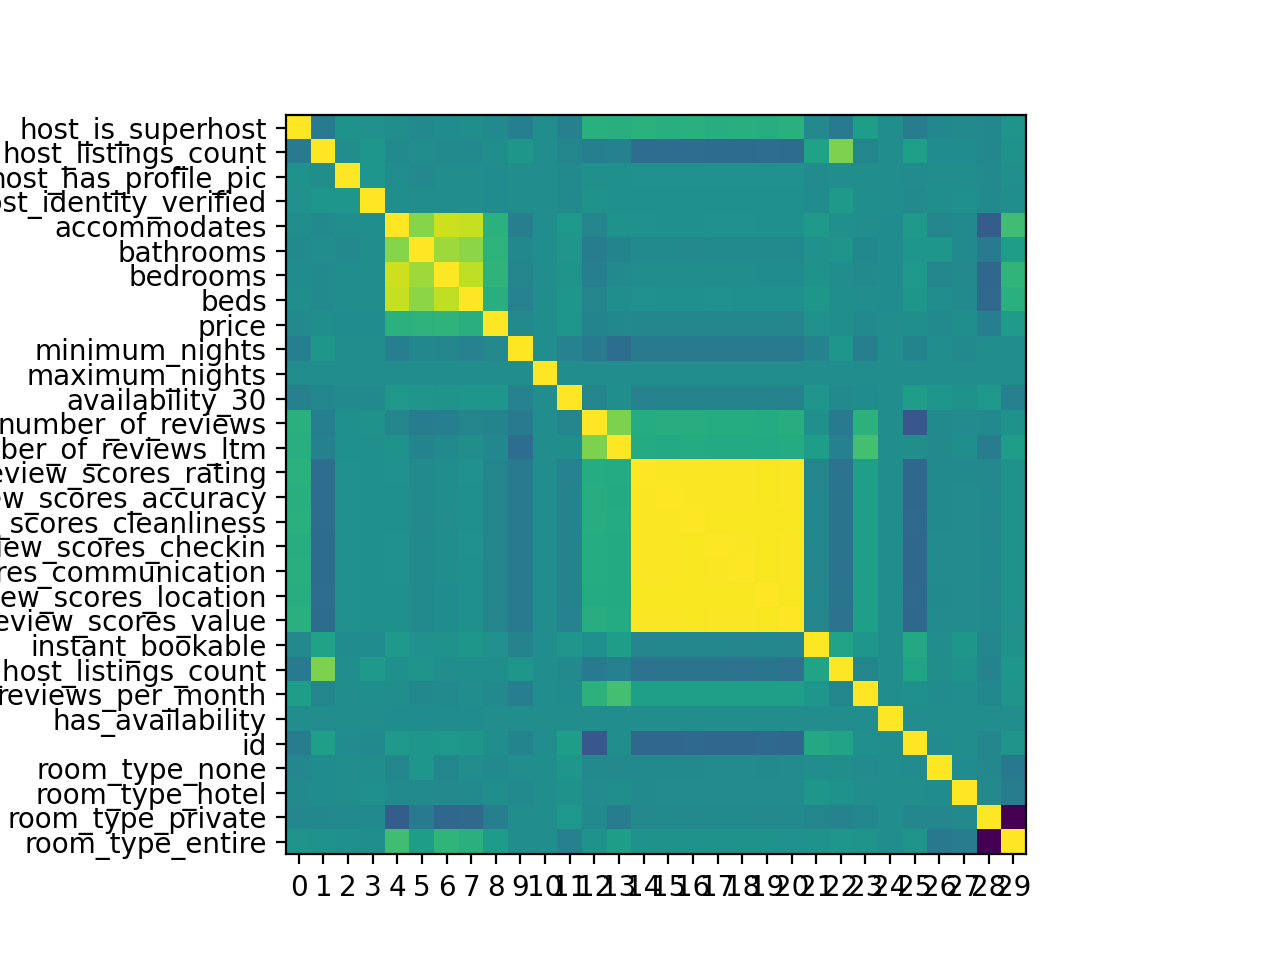

In [57]:
# now lets start looking at the data to get some future steps
corr_mat = np.corrcoef(np.array(numeric_data).T)
fig,ax = plt.subplots()
ax.set_xticks(np.arange(len(numeric_data.keys())))
ax.set_yticks(np.arange(len(numeric_data.keys())))
# ax.set_xticklabels(numeric_data.keys())
ax.set_yticklabels(numeric_data.keys())
ax.imshow(corr_mat)

In [58]:
# one glaring thing is that all the reviews are almost perfectly correlated, so I'm just going to
# take the mean of them and group them all into 'reviews'
reviews = ['review_scores_value', 'review_scores_rating',
           'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
           'review_scores_communication', 'review_scores_location']
numeric_data['reviews'] = numeric_data[reviews].mean(axis=1)
for review in reviews:
    numeric_data.drop(review,axis=1, inplace=True)

<IPython.core.display.Javascript object>


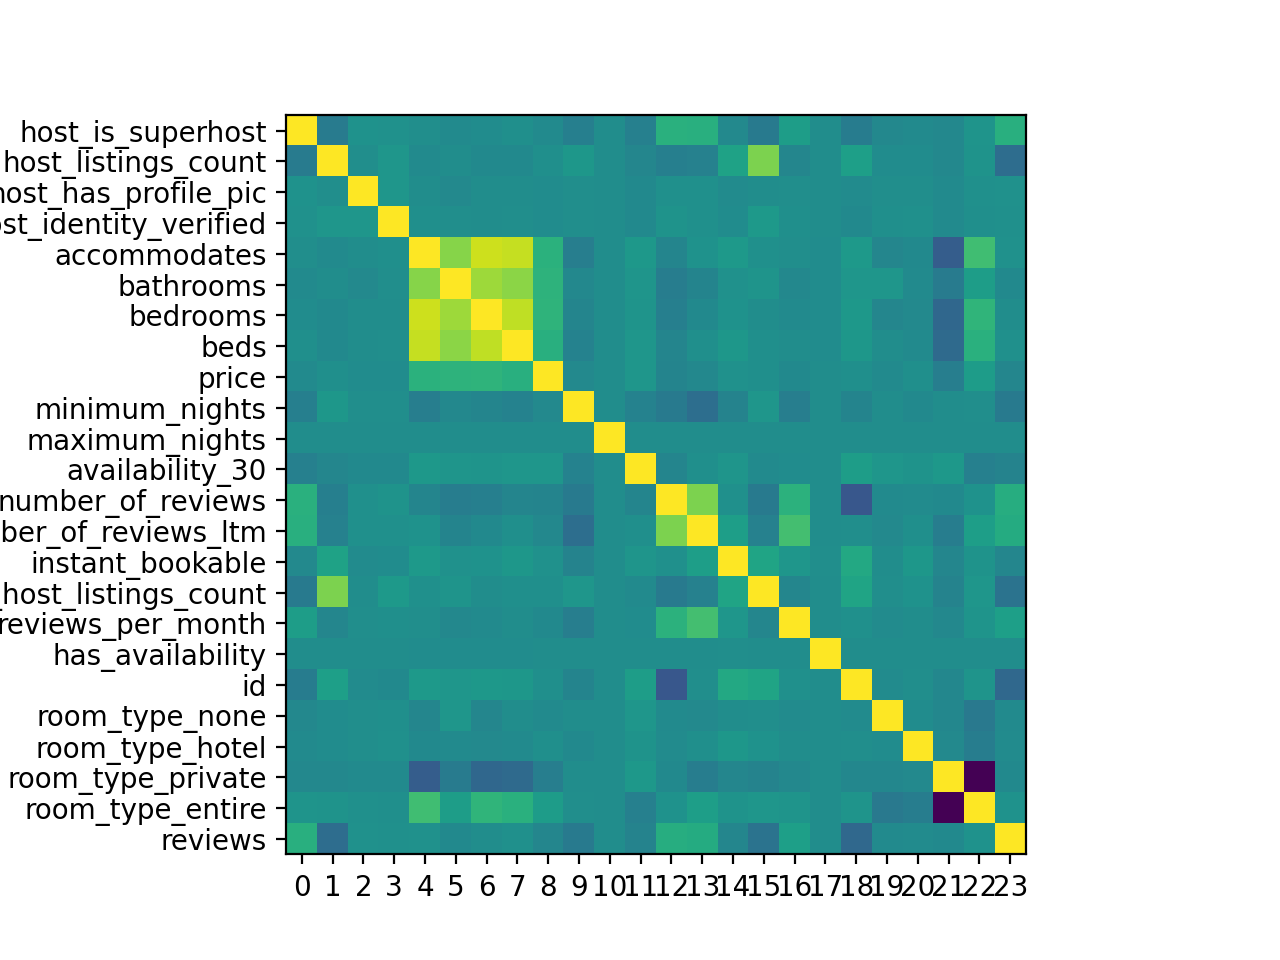

In [59]:
# lets look again at how correlated things are
corr_mat = np.corrcoef(np.array(numeric_data).T)
fig,ax = plt.subplots()
ax.set_xticks(np.arange(len(numeric_data.keys())))
ax.set_yticks(np.arange(len(numeric_data.keys())))
# ax.set_xticklabels(numeric_data.keys())
ax.set_yticklabels(numeric_data.keys())
ax.imshow(corr_mat)

In [70]:
# This looks better now, still some relatively high correlations between beds, bedrooms, bathrooms,
# and accomodates, but the highest is .83 so still a fair bit of independent information

# finally lets calculate our prediction variable which I'll call monthly income, this will 
# definitely be an imperfect measure of monthly income, but it will essentially be the number of
# non available days over the next 30 days times the price per day.

numeric_data['monthly_income'] = numeric_data['price'] * np.abs(numeric_data['availability_30'] - 30)

# first just try a simple linear regression without much more pre-processing of features
features = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified',
            'accommodates', 'bathrooms', 'bedrooms', 'beds',
            'maximum_nights',  'number_of_reviews', 
            'number_of_reviews_ltm', 'instant_bookable',
            'calculated_host_listings_count', 'reviews_per_month',
            'room_type_none', 'room_type_hotel', 'room_type_private', 'room_type_entire',
            'reviews']

In [79]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
regression = LinearRegression()
kfold = KFold(5, shuffle=False)
cv_scores = []
coefs = []

for train_idx,test_idx in kfold.split(numeric_data[features]):
    regression.fit(numeric_data[features].iloc[train_idx],numeric_data['price'].iloc[train_idx])
    r2=regression.score(numeric_data[features].iloc[test_idx],numeric_data['price'].iloc[test_idx])
    cv_scores.append(r2)
    coefs.append(regression.coef_)
    print(r2)
# ceiling is an r2 of .75 with the price information
# with shuffle=false on the kfold, we do much better, this currently has no location data so that is probably why unshuffled is better
# mean r2 of .25 with linear regression and a paired down set of regressors, pretty low starting
# point so lets see if we can do better in other files.

-0.031620159373777046
0.2600329703155313
0.29938481873328104
0.037194593177434454
0.17813851517519597


In [73]:
# let me just standardize the features and see if that helps at all
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = scaler.fit_transform(numeric_data[features])
cv_scores = []
coefs = []
for train_idx,test_idx in kfold.split(X):
    regression.fit(X[train_idx],numeric_data['monthly_income'].iloc[train_idx])
    r2=regression.score(X[test_idx],numeric_data['monthly_income'].iloc[test_idx])
    cv_scores.append(r2)
    coefs.append(regression.coef_)
# now that all the values are on the same scale, lets peek into the weights to see which seem most 
# important
coefs = np.mean(coefs, axis = 0)
for i in range(len(coefs)):
    print(features[i] + ' weight: {:1.3f}'.format(coefs[i]))

host_is_superhost weight: 255.384
host_has_profile_pic weight: 1109.433
host_identity_verified weight: -81.585
accommodates weight: -704.564
bathrooms weight: 73687.050
bedrooms weight: 25779.416
beds weight: 13595.620
maximum_nights weight: 700.714
number_of_reviews weight: 826.842
number_of_reviews_ltm weight: -15319.682
instant_bookable weight: 119.383
calculated_host_listings_count weight: 1261.339
reviews_per_month weight: -3898.808
room_type_none weight: -21350633133526360.000
room_type_hotel weight: -21350633133521484.000
room_type_private weight: -21350633133524080.000
room_type_entire weight: -21350633133522616.000
reviews weight: -363.066


In [75]:
# ok some things here make sense, like the strongest weights are on #beds and price, but some are weird,
# like bathrooms is strongly negtive, might be some nonlinear interactions here that would be better
# modeled another way.

# try a simple feed-forward NN to improve prediction
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split

trainX, testX, trainY, testY = train_test_split(X,numeric_data['monthly_income'], test_size = .2)
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(38, kernel_initializer='lecun_normal',input_dim = trainX.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(76, kernel_initializer='lecun_normal',activation='relu'))
NN_model.add(Dense(76, kernel_initializer='lecun_normal',activation='relu'))
# NN_model.add(Dense(76, kernel_initializer='lecun_normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='lecun_normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

# train the model
NN_model.fit(trainX, trainY, epochs=20, batch_size=64)

# test it
NN_model.evaluate(testX, testY, batch_size=64)

from sklearn.metrics import r2_score

predictions = NN_model.predict(testX)
print(r2_score(predictions,testY))
# we get slightly better predictions using this pretty large NN than linear regression...
# but its only doing about 6 points better


# next I'm going to explore a few of the wordy columns to see if theres any promising information
# there

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 38)                722       
                                                                 
 dense_16 (Dense)            (None, 76)                2964      
                                                                 
 dense_17 (Dense)            (None, 76)                5852      
                                                                 
 dense_18 (Dense)            (None, 1)                 77        
                                                                 
Total params: 9,615
Trainable params: 9,615
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
96940/96940 [==============================] - 101s 1ms/step - loss: 2037.3347 - mean_absolute_error: 2037.3347
Epoch 2/20
96940/96940 [==============================] - 102

In [78]:
from itertools import permutations
len(list(permutations(range(3),3)))

6